<a href="https://colab.research.google.com/github/Subedi1018/Data_science_thesis/blob/master_b/CS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [ ]:
train = pd.read_csv('drive/MyDrive/dr_train.csv')
test = pd.read_csv('drive/MyDrive/dr_test.csv')

In [ ]:
#Shape of dataset
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [ ]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Split features and target
X = train.drop(['label'], 1).values
y = train['label'].values

<ipython-input-6-1e51ee2bfd2b>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['label'], 1).values


In [ ]:
# Normalization
X = X / 255.0

In [ ]:
# Reshape
X = X.reshape(-1,28,28,1)

In [ ]:
# One hot encoding
y = to_categorical(y)

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

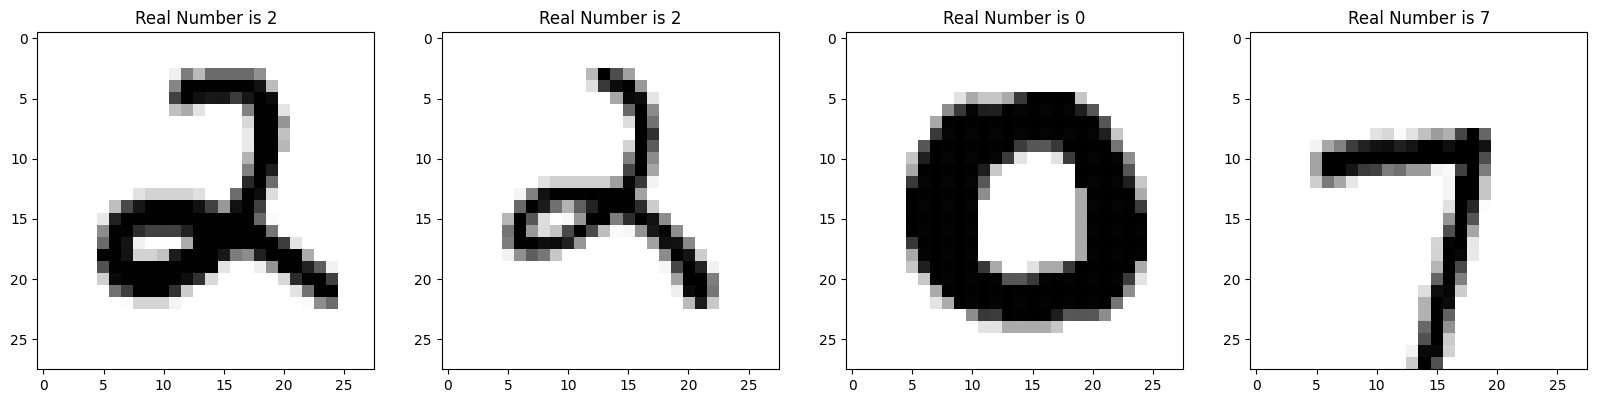

In [ ]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [ ]:
# Further Normalization
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

In [ ]:
# Defining the model
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))

model.add(Dense(10,activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 12, 12, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [ ]:
# Data Augmentation
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [ ]:
# Defining hyperparameters and callbacks
epochs = 10
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, #
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
# Fit the model -> Training
# Fit the model
history = model.fit(train_gen,
                      epochs = epochs,
                      steps_per_epoch = train_steps,
                      validation_data = test_gen,
                      validation_steps = valid_steps,
                      callbacks=[es, rp])

Epoch 1/10
295/295 [==============================] - ETA: 0s - loss: 0.0879 - accuracy: 0.9727

295/295 [==============================] - 277s 939ms/step - loss: 0.0879 - accuracy: 0.9727 - val_loss: 1.2652 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 2/10
295/295 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9821

295/295 [==============================] - 270s 915ms/step - loss: 0.0583 - accuracy: 0.9821 - val_loss: 0.0743 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 3/10
295/295 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9866

295/295 [==============================] - 273s 924ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.0521 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 4/10
295/295 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9881

295/295 [==============================] - 272s 922ms/step - loss: 0.0391 - accuracy: 0.9881 - val_loss: 0.0618 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 5/10
295/295 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9890

295/295 [==============================] - 271s 920ms/step - loss: 0.0356 - accuracy: 0.9890 - val_loss: 0.0382 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 6/10
295/295 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9896

295/295 [==============================] - 270s 912ms/step - loss: 0.0346 - accuracy: 0.9896 - val_loss: 0.0410 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 7/10
295/295 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9907

295/295 [==============================] - 271s 918ms/step - loss: 0.0320 - accuracy: 0.9907 - val_loss: 0.0416 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 8/10
295/295 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9916

295/295 [==============================] - 267s 902ms/step - loss: 0.0285 - accuracy: 0.9916 - val_loss: 0.0488 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 9/10
295/295 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9901

295/295 [==============================] - 268s 910ms/step - loss: 0.0324 - accuracy: 0.9901 - val_loss: 0.0444 - val_accuracy: 0.9878 - lr: 0.0010
Epoch 10/10
295/295 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9920

295/295 [==============================] - 275s 932ms/step - loss: 0.0260 - accuracy: 0.9920 - val_loss: 0.0352 - val_accuracy: 0.9902 - lr: 0.0010


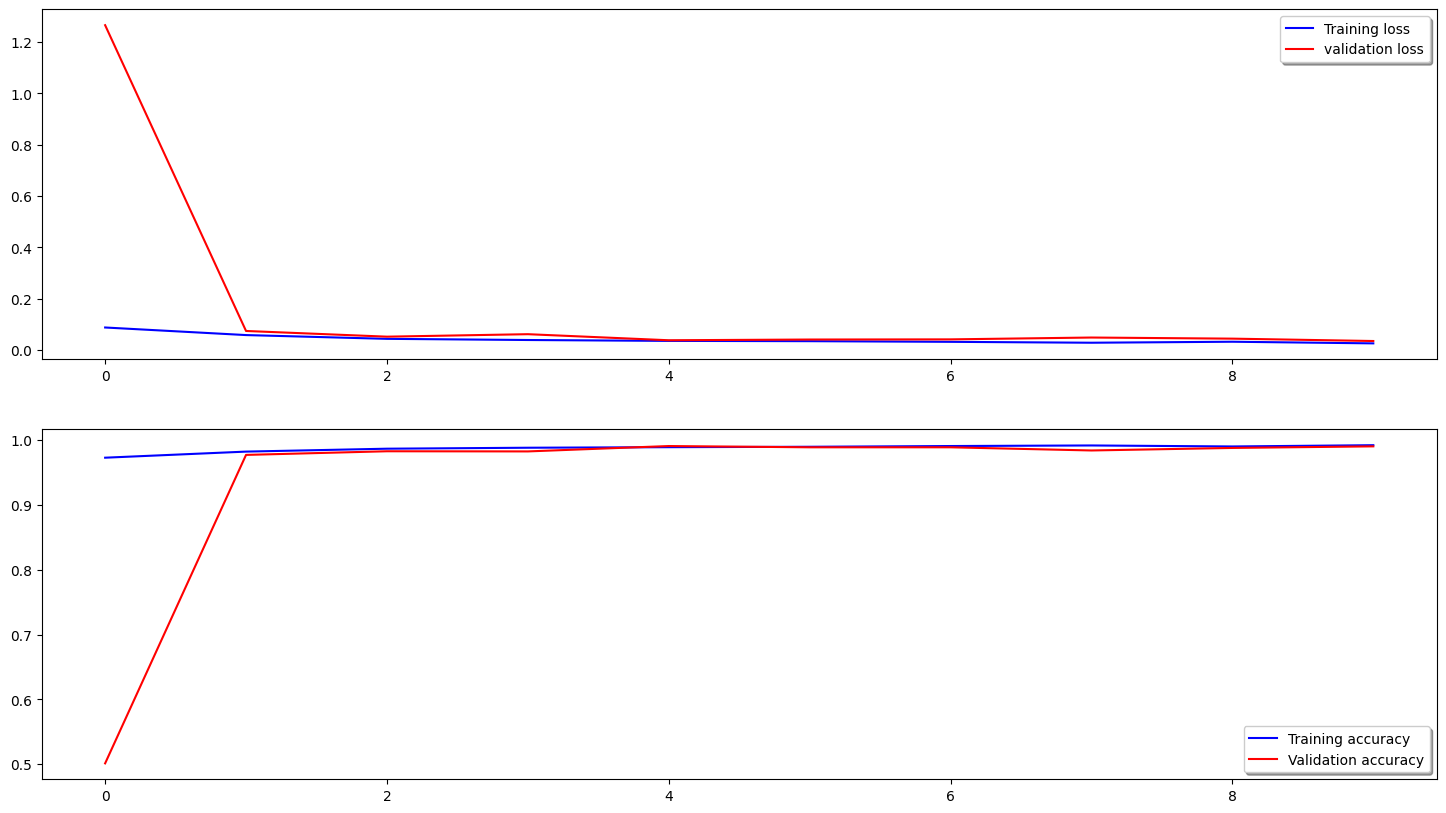

In [ ]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

132/132 [==============================] - 9s 61ms/step


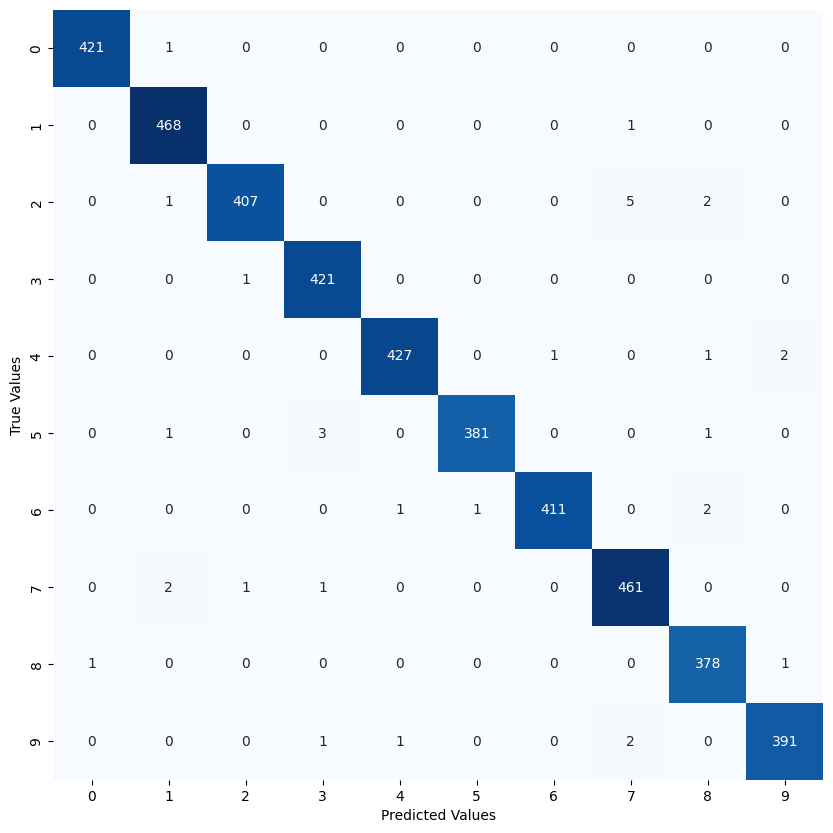

In [ ]:
#Plotting Confusion Matrix
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

132/132 [==============================] - 9s 72ms/step


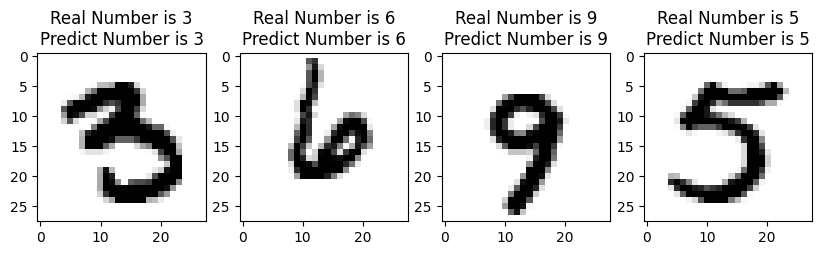

In [ ]:
# Predicting the test dataset
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(10, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");